# Address Interpolation

## Objective

Given a missing house address, predict its coordinates (longitude and latitude).

## Variables

* House number
* Street name
* Street tags (optional)
* Admin hierarchy (optional)
* Coordinates of projection onto street (target)

## Dataset

* House number and street name come from OpenAddresses.
* Street tags and geometry come from Openstreetmap (OSM).
* Street geometry is used to derive the target variable. Streets in OSM have a `highway` tag.
* Admin hierarchy will be fetched from a point-in-polygon service.

In [1]:
import glob
import json
import urllib
import ntpath
import operator
import functools
import numpy as np
import pandas as pd
import osmnx as ox
import seaborn as sns
import matplotlib as mpl
from geopy import distance
import matplotlib.pyplot as plt
from itertools import groupby, combinations
from sklearn.metrics import average_precision_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
from sklearn.neighbors import KNeighborsClassifier

In [2]:
%matplotlib inline

mpl.rcParams['figure.dpi'] = 200
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12.5,9.7)})

### Load Data

In [3]:
def add_street_prop(filename, street):
    base = ntpath.basename(filename)
    without_ext = base.split('.')[0]
    without_id = without_ext.split('__')[1]
    street_name = urllib.parse.unquote_plus(without_id)
    for x in street:
        x.update({'street': street_name})
    return street

def read_json(file):
    with open(file) as f:
        street = json.load(f)
        return add_street_prop(file, street)

def read_jsons(files):
    return [read_json(f) for f in files]

def dedupe_street(street):
    seen = set()
    return [x for x in street if [(x['street'], x['housenumber'])
                                  not in seen, seen.add((x['street'], x['housenumber']))][0]]

def get_streets(blob):
    encoded_blob = urllib.parse.quote_plus(blob)
    files = glob.glob(f'./data/streets/*{encoded_blob}*')
    nested = read_jsons(files)
    full = functools.reduce(operator.iconcat, nested, [])
    return dedupe_street(full)

In [4]:
all_streets = get_streets('')
all_streets[:2]

[{'rowid': 357377,
  'id': 14889,
  'source': 'OA',
  'source_id': '4b6fcce92fe852f7',
  'housenumber': 2,
  'lat': 52.5665096,
  'lon': 13.2221506,
  'parity': 'R',
  'proj_lat': 52.5666038704211,
  'proj_lon': 13.221891523899563,
  'marker-color': '#ff0000',
  'marker-symbol': 'e',
  'street': 'Elkartweg'},
 {'rowid': 357378,
  'id': 14889,
  'source': 'OA',
  'source_id': '5dd2114a2c898e3a',
  'housenumber': 3,
  'lat': 52.5666823,
  'lon': 13.2217923,
  'parity': 'L',
  'proj_lat': 52.56663502950204,
  'proj_lon': 13.221922210873217,
  'marker-color': '#3366ff',
  'marker-symbol': 'o',
  'street': 'Elkartweg'}]

In [35]:
def sort_street(street):
    return sorted(street, key=lambda k: k['housenumber'])

def group_streets(streets):
    grouped_streets = {}
    for k, v in groupby(streets, key=lambda x:x['street']):
        existing_group = grouped_streets[k] if k in grouped_streets else []
        grouped_streets[k] = existing_group + sort_street(list(v))
    return grouped_streets

In [36]:
grouped_streets = group_streets(all_streets)
grouped_streets['Sollstedter Straße']

[{'rowid': 86024,
  'id': 31023,
  'source': 'OA',
  'source_id': '34d1a42e672fee26',
  'housenumber': 1,
  'lat': 52.5367362,
  'lon': 13.5061264,
  'parity': 'L',
  'proj_lat': 52.53655284935239,
  'proj_lon': 13.506163861224355,
  'marker-color': '#3366ff',
  'marker-symbol': 'o',
  'street': 'Sollstedter Straße'},
 {'rowid': 86025,
  'id': 31023,
  'source': 'OA',
  'source_id': 'c18b778351216149',
  'housenumber': 3,
  'lat': 52.5367547,
  'lon': 13.5063783,
  'parity': 'L',
  'proj_lat': 52.53657188238236,
  'proj_lon': 13.506415652349999,
  'marker-color': '#3366ff',
  'marker-symbol': 'o',
  'street': 'Sollstedter Straße'},
 {'rowid': 86026,
  'id': 31023,
  'source': 'OA',
  'source_id': '4b770ed1512914ea',
  'housenumber': 5,
  'lat': 52.5367708,
  'lon': 13.5066822,
  'parity': 'L',
  'proj_lat': 52.5365947498345,
  'proj_lon': 13.506718169685563,
  'marker-color': '#3366ff',
  'marker-symbol': 'o',
  'street': 'Sollstedter Straße'},
 {'rowid': 161475,
  'id': 31023,
  'sour

### Previous and Next Address

Add features to each address telling it where its sequential neighbors are located.

In [37]:
def add_prev_next(street):
    for idx, x in enumerate(street):
        if idx > 0 and idx < (len(street) - 1):
            x['prev_lat'] = street[idx - 1]['proj_lat']
            x['prev_lon'] = street[idx - 1]['proj_lon']
            x['next_lat'] = street[idx + 1]['proj_lat']
            x['next_lon'] = street[idx + 1]['proj_lon']
        elif idx == 0:
            x['prev_lat'] = 0
            x['prev_lon'] = 0
            x['next_lat'] = street[idx + 1]['proj_lat']
            x['next_lon'] = street[idx + 1]['proj_lon']
        elif idx == (len(street) - 1):
            x['prev_lat'] = street[idx - 1]['proj_lat']
            x['prev_lon'] = street[idx - 1]['proj_lon']
            x['next_lat'] = 0
            x['next_lon'] = 0

    return street

In [38]:
def prep_street(name):
    street = grouped_streets[name]
    street = sorted(street, key=lambda k: k['housenumber'])
    return add_prev_next(street)

In [39]:
landsberger_allee = prep_street('Landsberger Allee')
len(landsberger_allee)

362

In [49]:
landsberger_allee[:2]

[{'rowid': 349839,
  'id': 28846,
  'source': 'OA',
  'source_id': '6ea4d90e75cf9897',
  'housenumber': 2,
  'lat': 52.5230406,
  'lon': 13.4344582,
  'parity': 'R',
  'proj_lat': 52.523191973034486,
  'proj_lon': 13.434421937319877,
  'marker-color': '#ff0000',
  'marker-symbol': 'e',
  'street': 'Landsberger Allee',
  'prev_lat': 0,
  'prev_lon': 0,
  'next_lat': 52.52320633187243,
  'next_lon': 13.434586673049742},
 {'rowid': 349840,
  'id': 28846,
  'source': 'OA',
  'source_id': 'cd1b022bc8ef6b9a',
  'housenumber': 4,
  'lat': 52.5230755,
  'lon': 13.4346163,
  'parity': 'R',
  'proj_lat': 52.52320633187243,
  'proj_lon': 13.434586673049742,
  'marker-color': '#ff0000',
  'marker-symbol': 'e',
  'street': 'Landsberger Allee',
  'prev_lat': 52.523191973034486,
  'prev_lon': 13.434421937319877,
  'next_lat': 52.52322547410281,
  'next_lon': 13.434857931689066}]

### Plot Streets

Text(0.5, 1.0, 'Berlin, Germany')

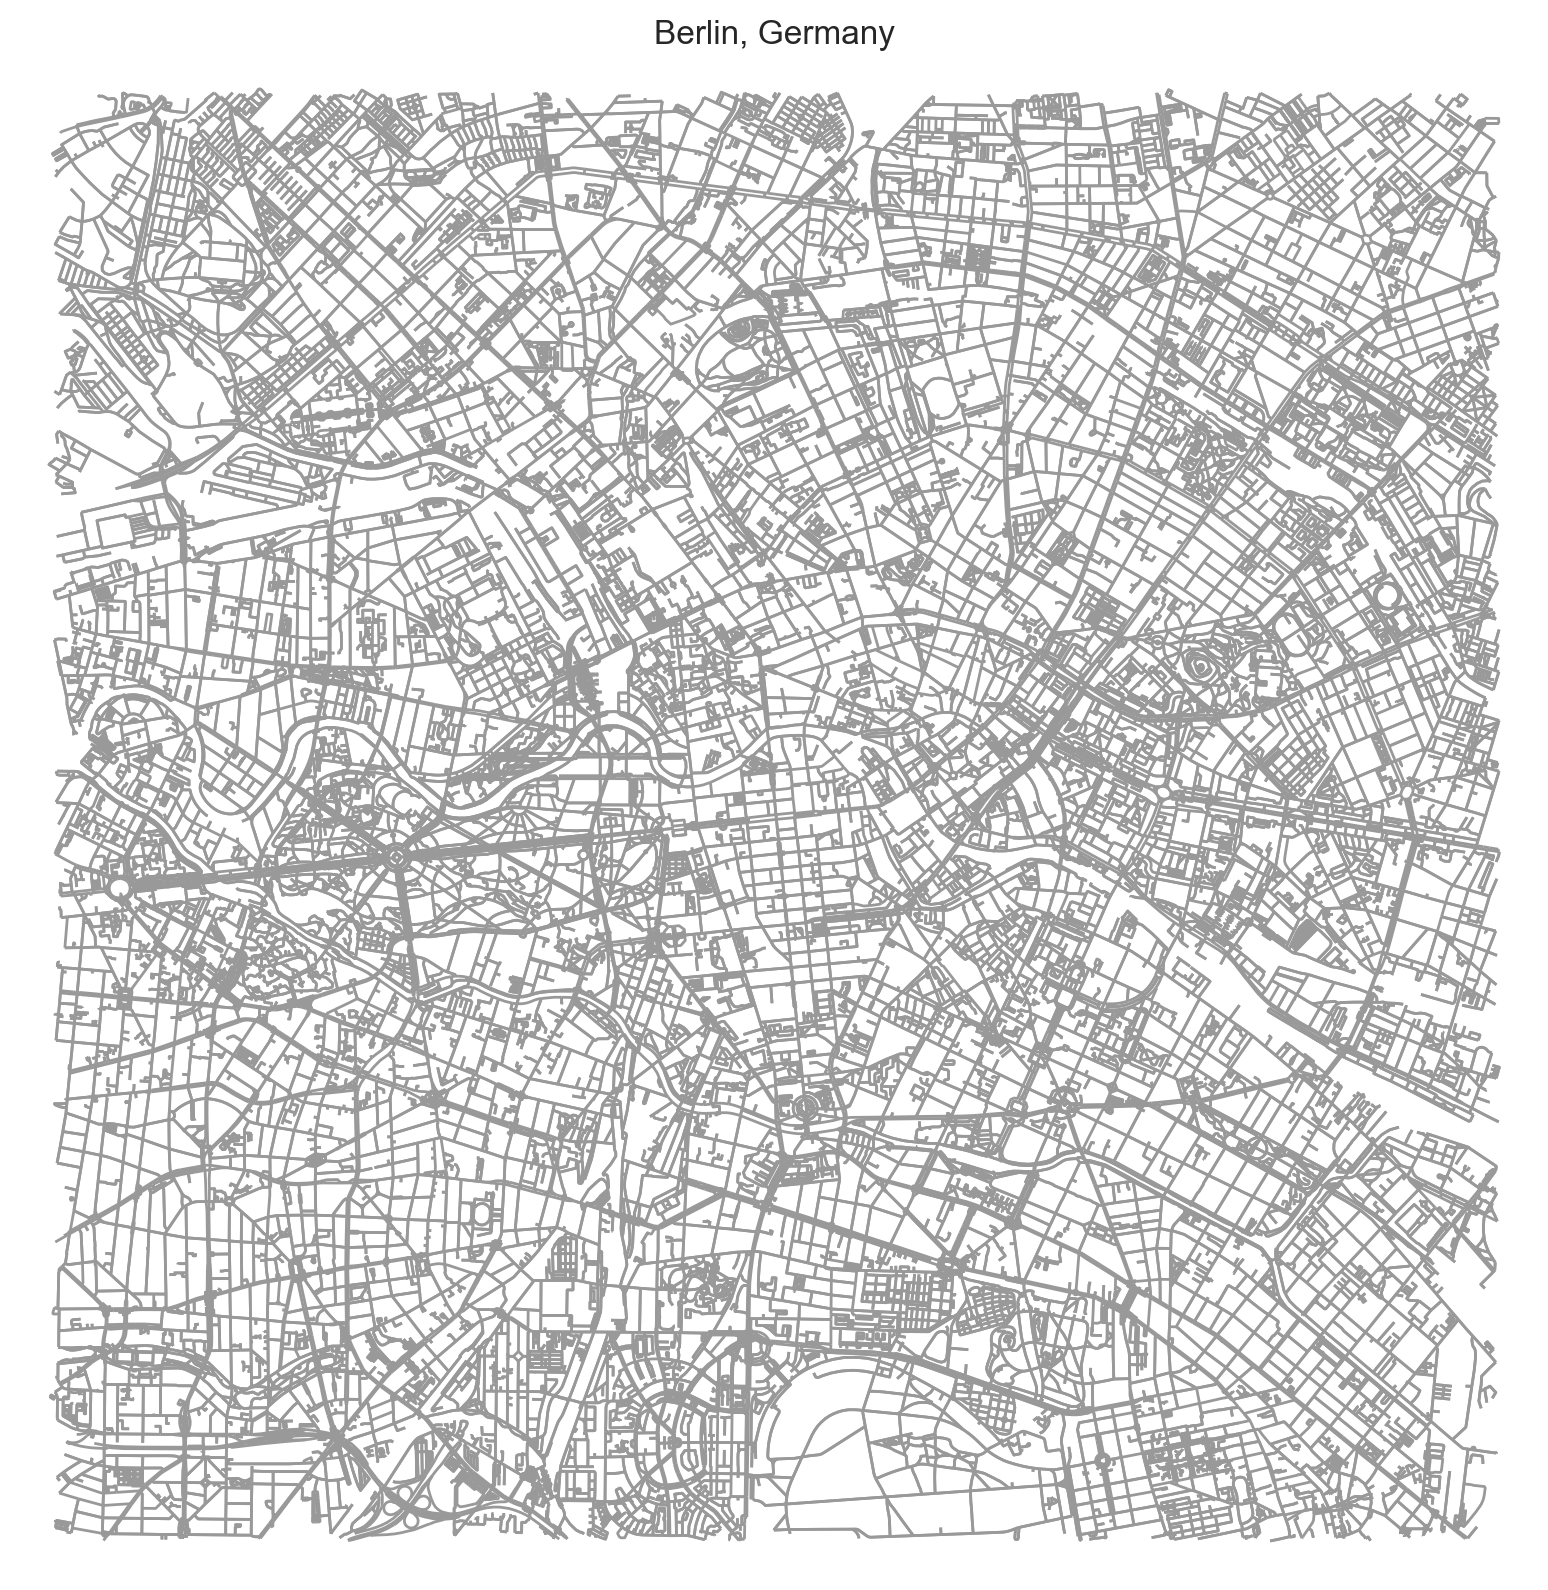

In [85]:
G = ox.graph_from_address('Berlin, Germany', distance=5000)
fig, ax = ox.plot_graph(G, fig_height=10, fig_width=10, show=False, close=False, node_color='none')
ax.set_title('Berlin, Germany')

In [86]:
def plot_street(streets, name, address, distance=1000):
    street = streets[name]
    lons = [x['proj_lon'] for x in street]
    lats = [x['proj_lat'] for x in street]
    G = ox.graph_from_address(address, distance=distance)
    fig, ax = ox.plot_graph(G, fig_height=10, fig_width=10, show=False, close=False, node_color='none')
    ax.scatter(lons, lats, c='red', s=20, marker='X', zorder=3)
    ax.set_title(address)
    # ax.plot(lons, lats, marker='o', markersize=5, color="red")
    # print(ax.get_ylim(), ax.get_xlim())

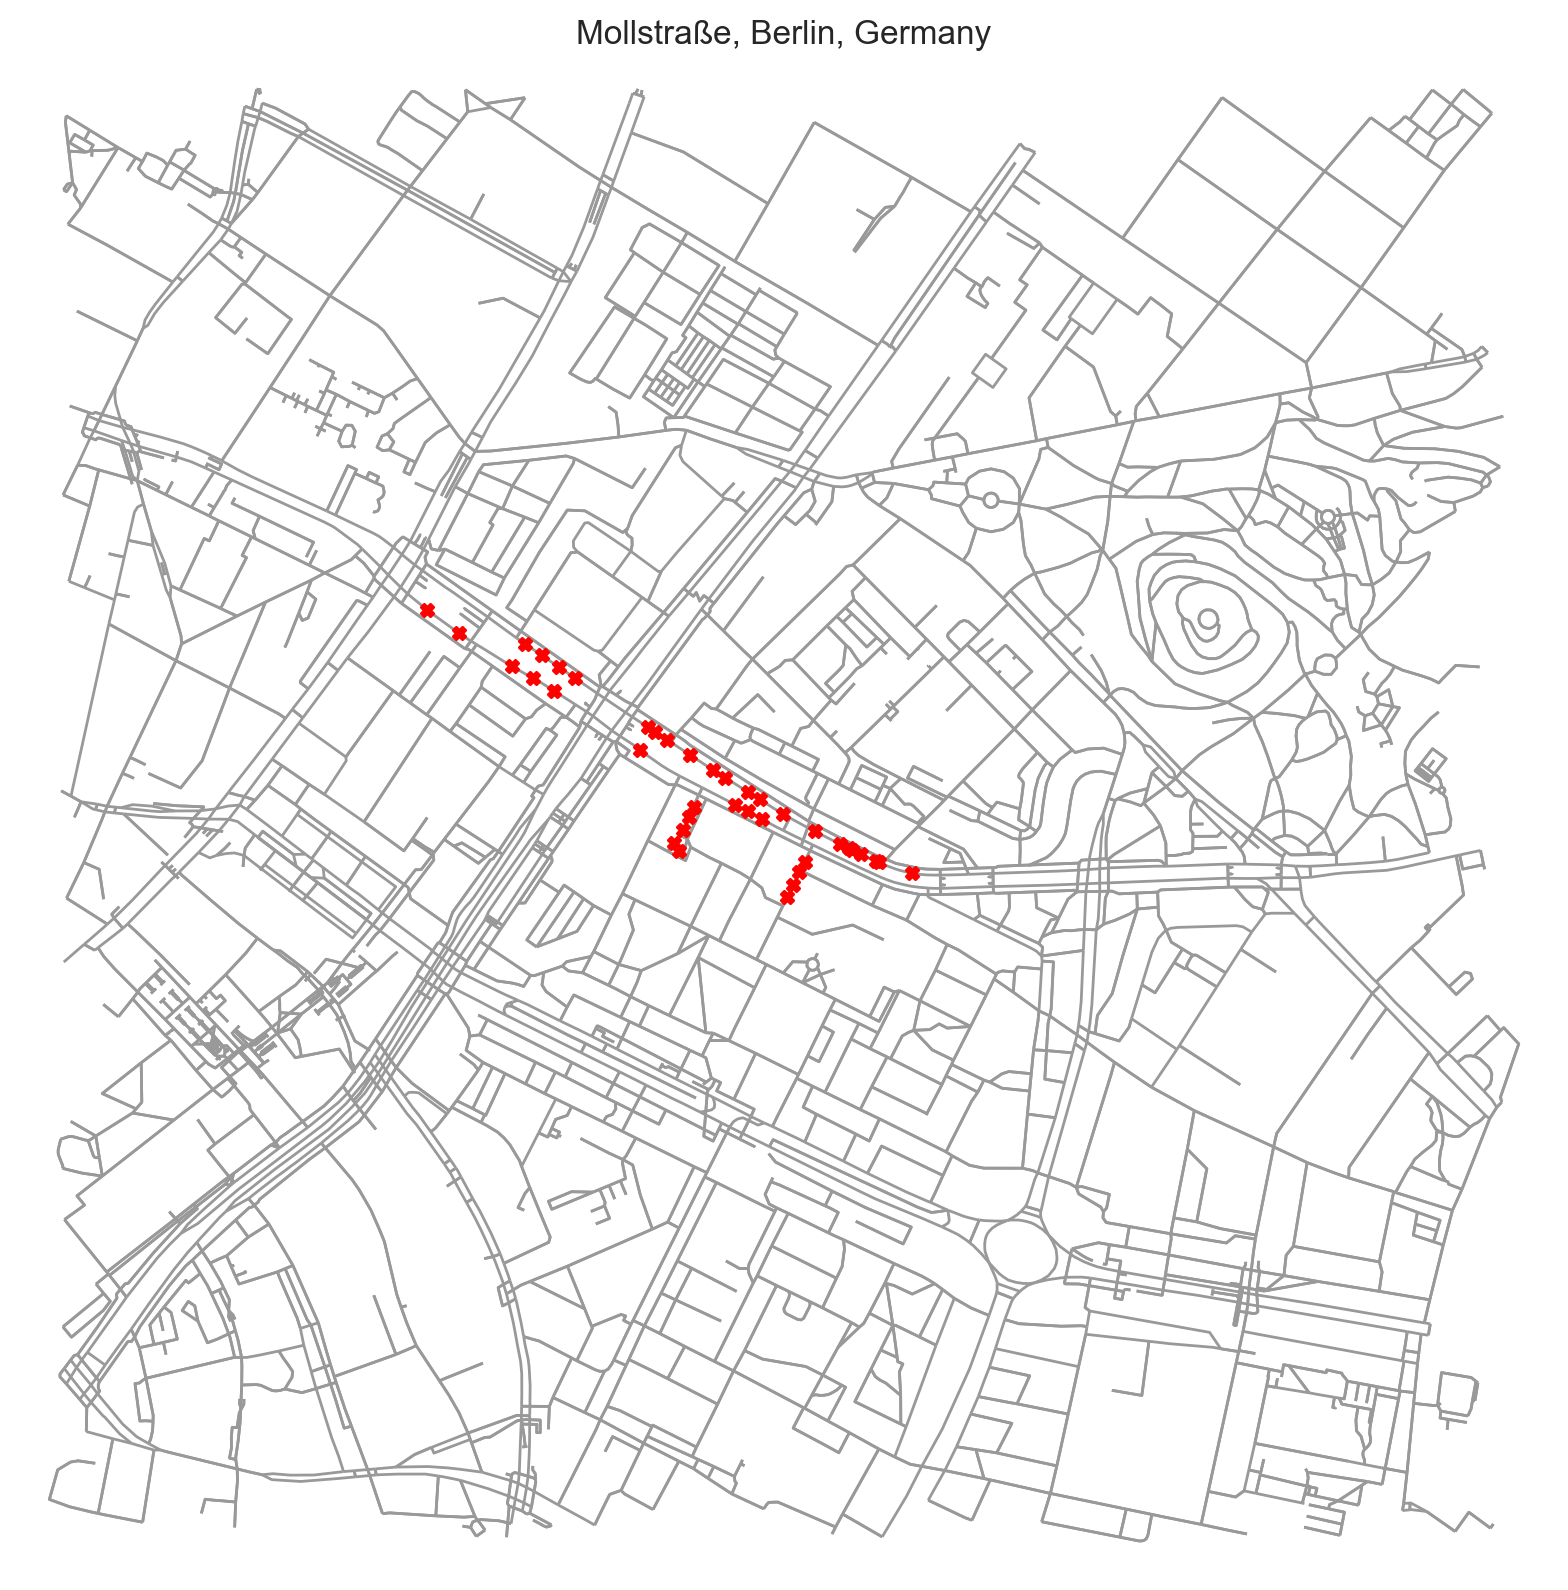

In [87]:
plot_street(grouped_streets, 'Mollstraße', 'Mollstraße, Berlin, Germany')

### Model Fitting

### Gaussian Process Regressor (GPR)

![](./images/Gaussian_Process_Regression.png)

In [45]:
def fit_gp(streets):
    features = np.array([[x['prev_lat'], x['prev_lon'], x['next_lat'], x['next_lon']] for x in streets])
    labels = np.array([[x['proj_lat'], x['proj_lon']] for x in streets])
    
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_features = enc.fit_transform(features)
    enc_features = enc_features.toarray()

    train_feats, test_feats = train_test_split(enc_features, test_size=0.25, random_state=42)
    train_labels, test_labels = train_test_split(labels, test_size=0.25, random_state=42)
    
    kernel = RBF()
    gpr = GaussianProcessRegressor(kernel=kernel,
            random_state=0).fit(train_feats, train_labels)
    
    train_predictions = gpr.predict(train_feats)
    training_score = mean_squared_error(train_predictions, train_labels)
    
    test_predictions = gpr.predict(test_feats)
    test_score = mean_squared_error(test_labels, test_predictions)
    
    all_predictions = gpr.predict(enc_features)
    all_score = mean_squared_error(labels, all_predictions)
    
    return (training_score, test_score, all_score, test_predictions, test_labels, all_predictions)


In [76]:
(_, gpr_score, _, test_predictions, test_labels, all_predictions) = fit_gp(landsberger_allee)
print(f'GPR Test MSE: {gpr_score}')

GPR Test MSE: 0.0011272474687725892


#### MSE for Latitude and Longitude

In [16]:
def lat_lon_mse(predictions, labels):
    pred_lats = np.array([i[0] for i in predictions])
    pred_lons = np.array([i[1] for i in predictions])
    label_lats = np.array([i[0] for i in labels])
    label_lons = np.array([i[1] for i in labels])
    lat_mse = ((pred_lats - label_lats)**2).mean()
    lon_mse = ((pred_lons - label_lons)**2).mean()
    return lat_mse, lon_mse

In [17]:
lat_lon_mse(test_predictions, test_labels)

(5.67819693094608e-05, 0.0021977129682357174)

__Notes:__

* Parity did not make a difference in test MSE. In fact it increases it by a tiny bit.
* RBF kernel performs way better than dot product.

In [18]:
def plot(lon_lats_1, lon_lats_2):
    lats_1 = [x[1] for x in lon_lats_1]
    lons_1 = [x[0] for x in lon_lats_1]
    lats_2 = [x[1] for x in lon_lats_2]
    lons_2 = [x[0] for x in lon_lats_2]
    
    plt.scatter(lats_1, lons_1, s=10)
    plt.scatter(lats_2, lons_2, c='red', s=10)

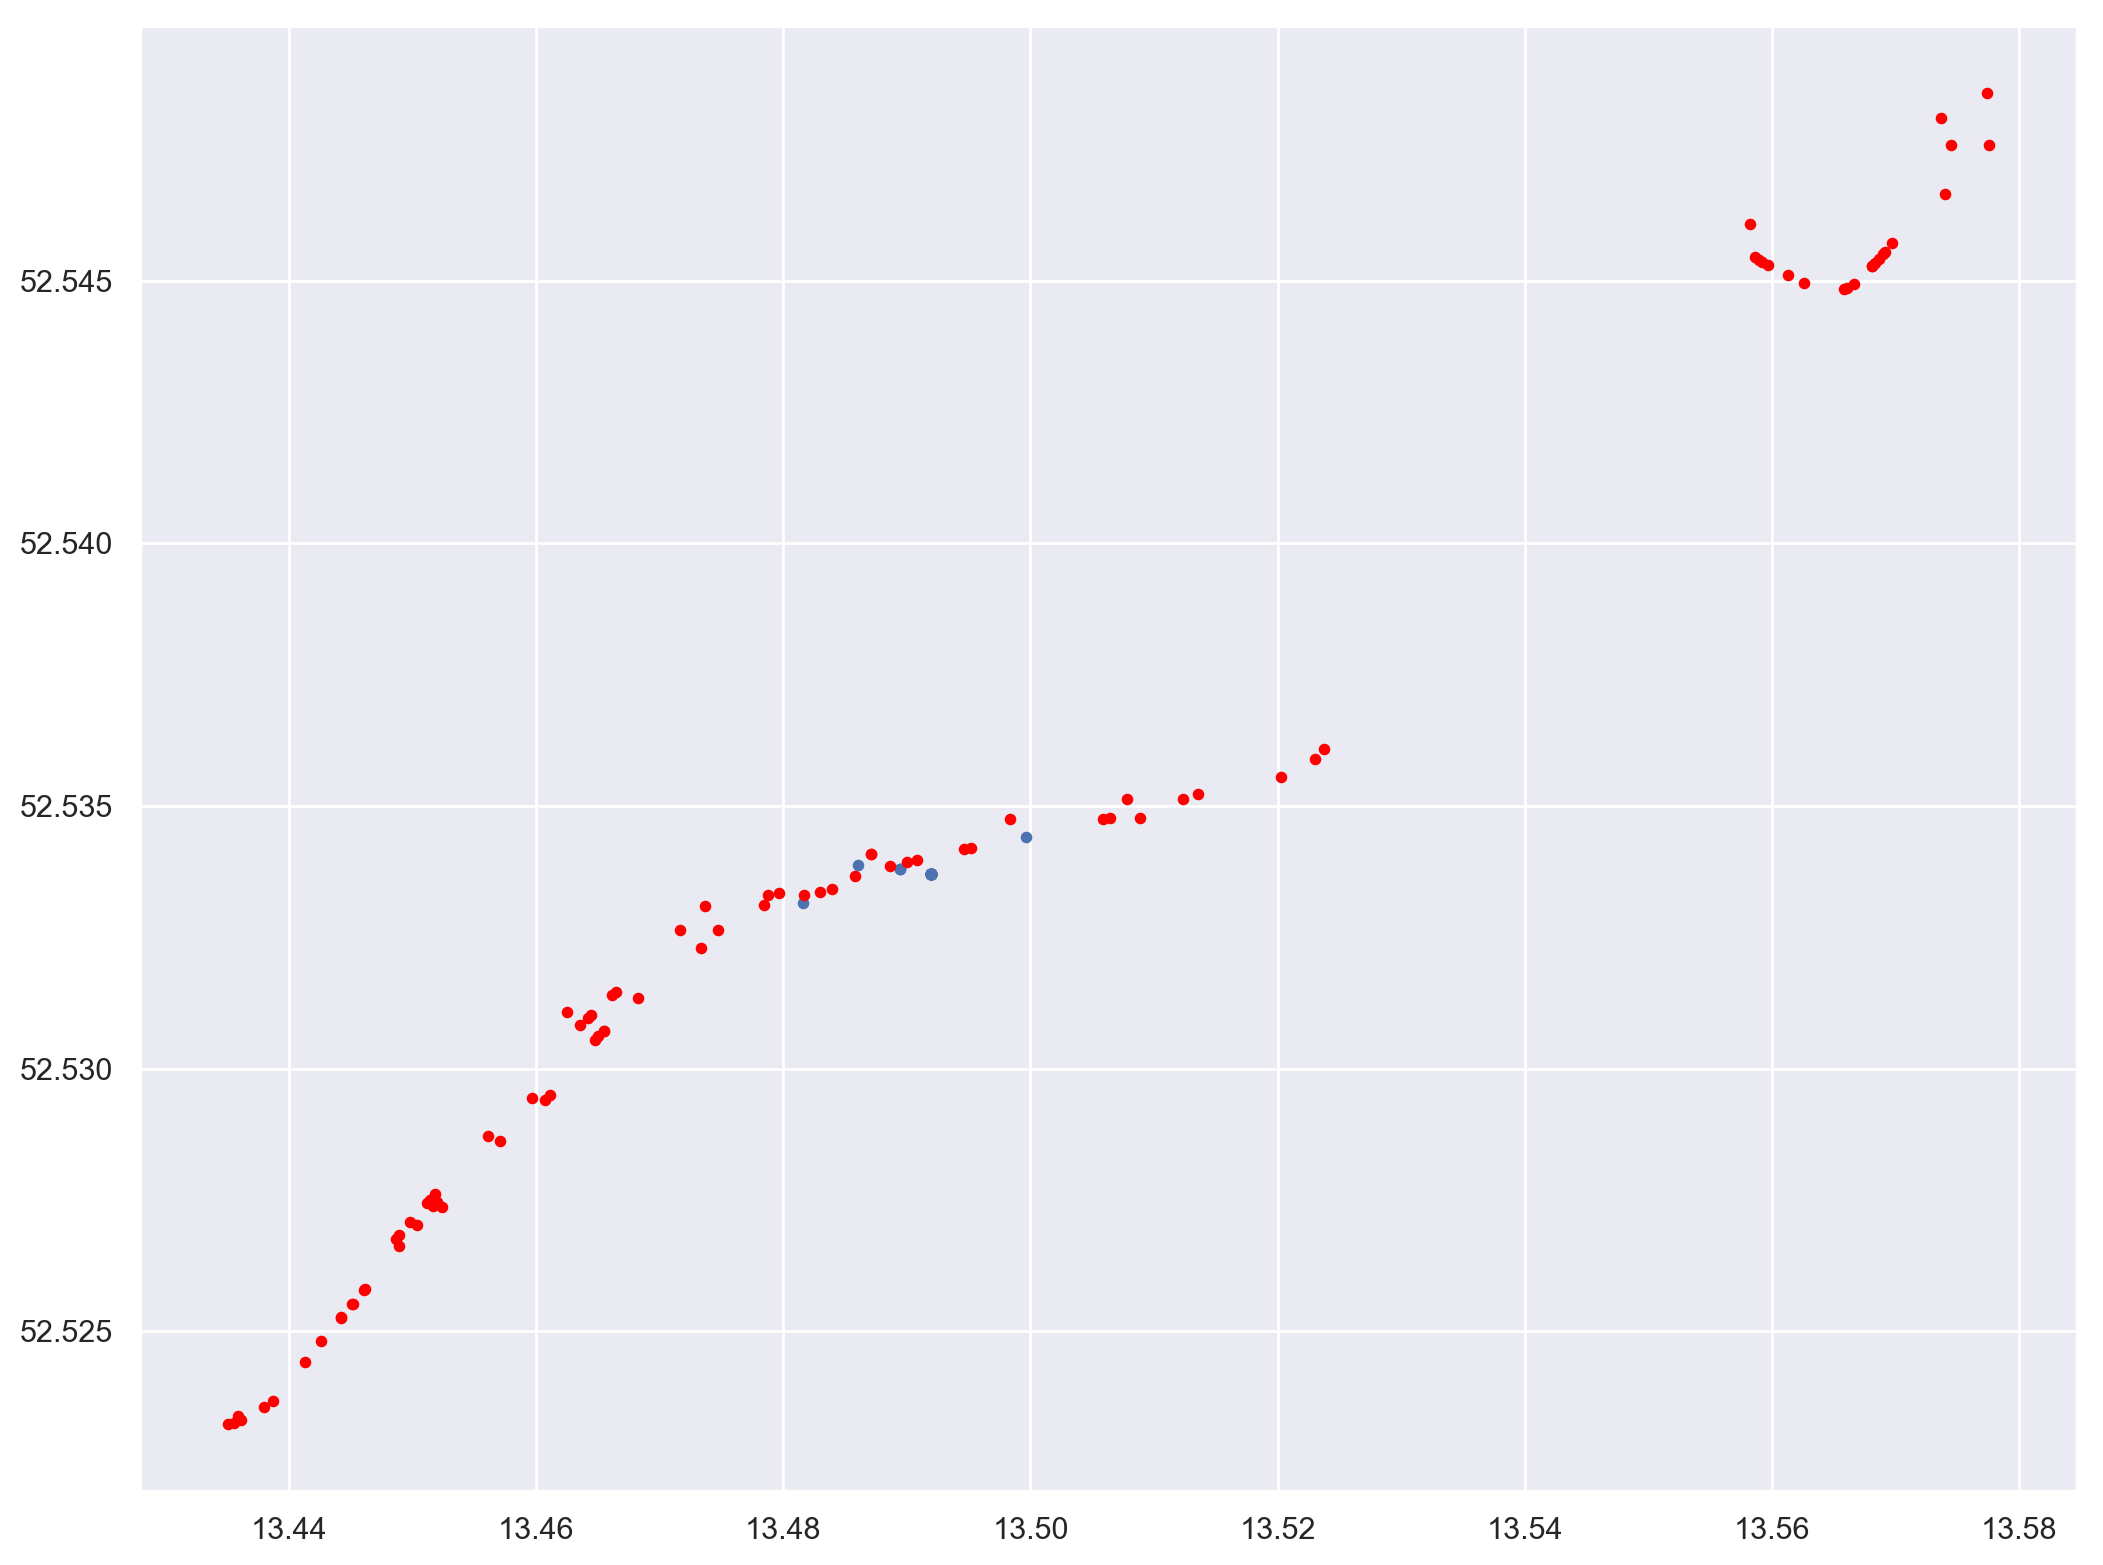

In [19]:
plot(test_predictions, test_labels)

#### Distance Errors in Meters

In [52]:
def address_distance(a1, a2):
    return distance.distance((a1[0], a1[1]), (a2[0], a2[1])).km

In [53]:
[address_distance(x,y) for (x,y) in zip(test_predictions, test_labels)][:10]

[0.33104008959991327,
 2.511416961975591,
 2.9723840084482442,
 6.042737454437654,
 2.1570212339095356,
 0.013107268220473384,
 1.942082440324638,
 0.9094288905384736,
 2.3131274501297714,
 0.8843845539226485]

In [75]:
def plot_street(pred_coords, label_coords, address, distance=2000):
    pred_lons = [x[1] for x in pred_coords]
    pred_lats = [x[0] for x in pred_coords]
    label_lons = [x[1] for x in label_coords]
    label_lats = [x[0] for x in label_coords]
    G = ox.graph_from_address(address, distance=distance)
    fig, ax = ox.plot_graph(G, fig_height=10, fig_width=10, show=False, close=False, node_color='none')
    ax.scatter(pred_lons, pred_lats, marker='X', s=15, c='blue', zorder=4)
    ax.scatter(label_lons, label_lats, marker='X', s=15, c='red', zorder=4)

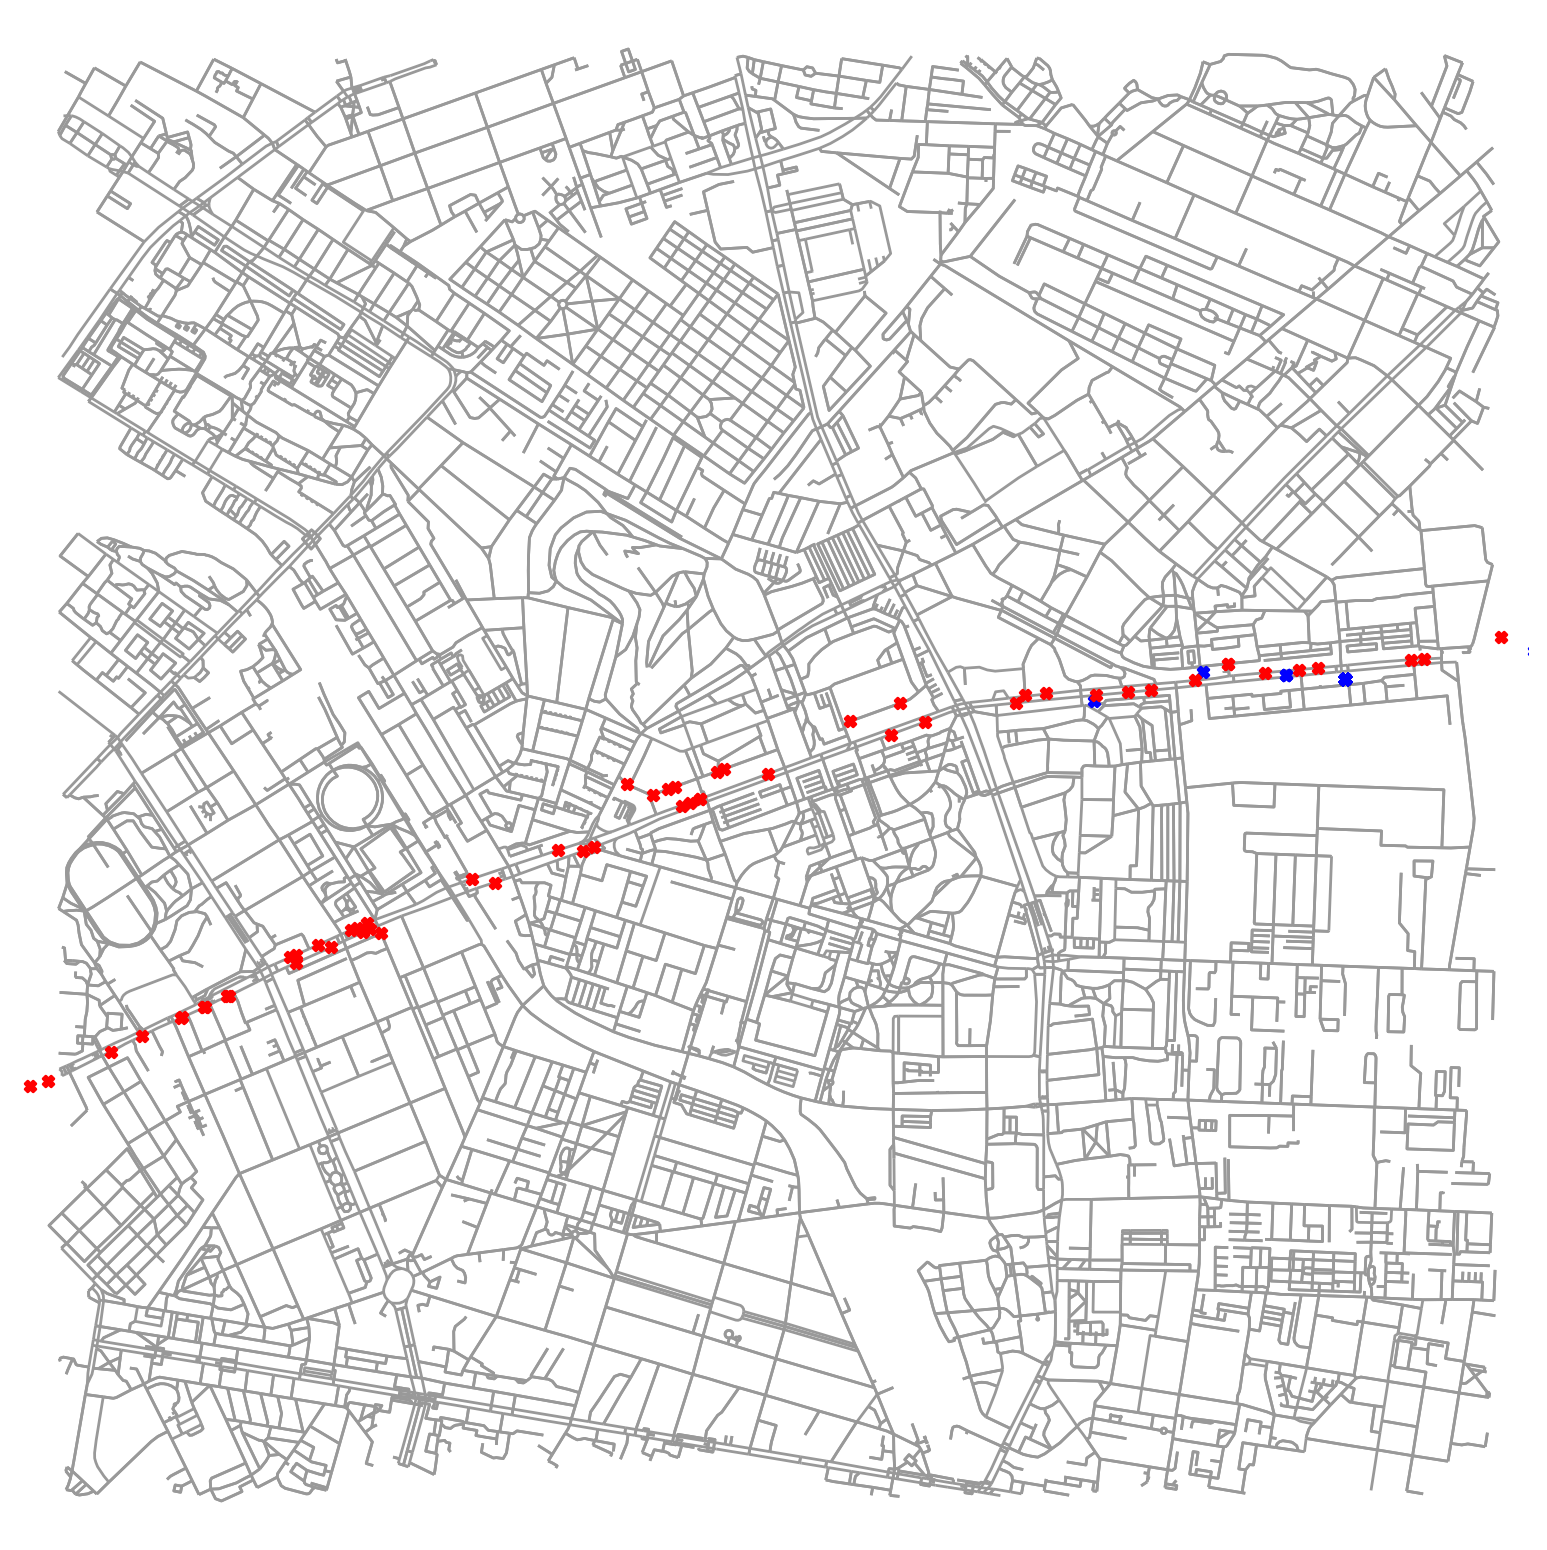

In [77]:
plot_street(test_predictions, test_labels, 'Landsberger Allee, Berlin, Germany')

### K-Nearest Neighbors (k-NN)

In [56]:
def fit_knn(streets, nn):
    features = np.array([[x['prev_lat'], x['prev_lon'], x['next_lat'], x['next_lon'], x['parity']] for x in streets])
    labels = np.array([[x['proj_lat'], x['proj_lon']] for x in streets])
    
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_features = enc.fit_transform(features)
    enc_features = enc_features.toarray()

    train_feats, test_feats = train_test_split(enc_features, test_size=0.25, random_state=42)
    train_labels, test_labels = train_test_split(labels, test_size=0.25, random_state=42)

    from sklearn.neighbors import KNeighborsRegressor
    
    neigh = KNeighborsRegressor(n_neighbors=nn)
    model = neigh.fit(train_feats, train_labels) 

    train_predictions = model.predict(train_feats)
    training_score = mean_squared_error(train_predictions, train_labels)

    test_predictions = model.predict(test_feats)
    test_score = mean_squared_error(test_labels, test_predictions)
    
    return (training_score, test_score, test_predictions, test_labels)

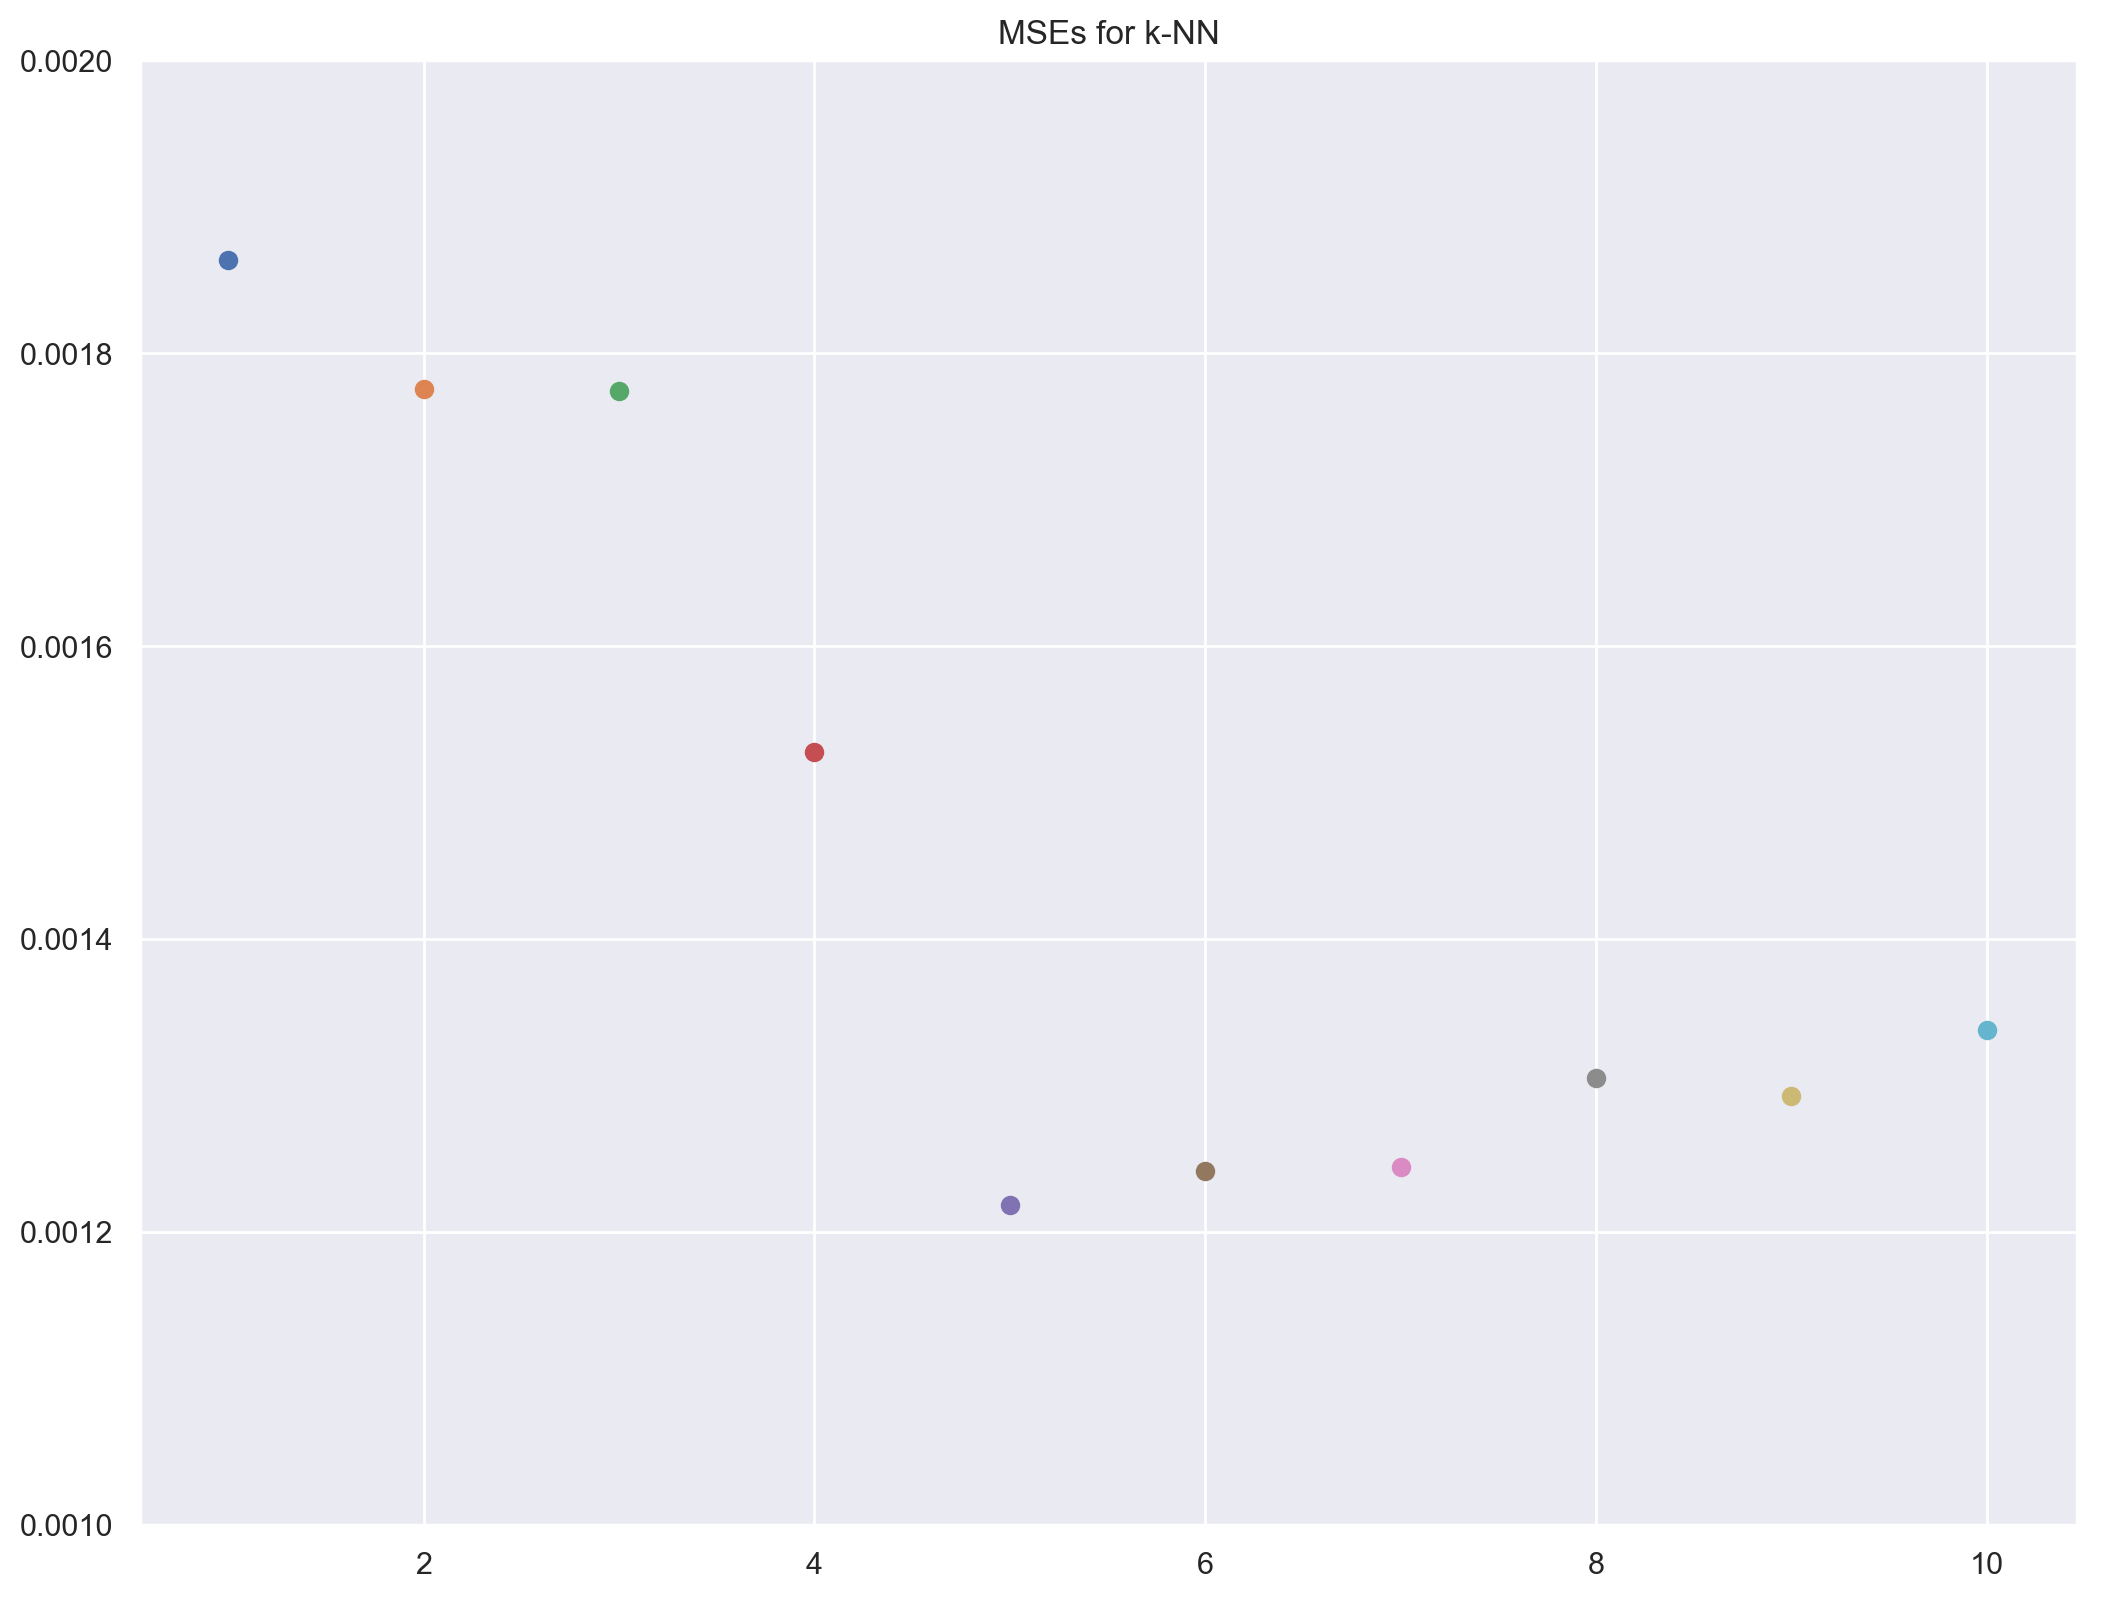

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim([0.001,0.002])
for i in range(1,11):
    _, knn_score, test_predictions, test_labels = fit_knn(landsberger_allee, i)
    ax.scatter(i, knn_score)
    
ax.set_title('MSEs for k-NN')
plt.show()

In [78]:
_, knn_score, test_predictions, test_labels = fit_knn(landsberger_allee, 5)
print(f'5-NN Test MSE: {knn_score}')

5-NN Test MSE: 0.0012182665140076433


__Notes:__

* Parity improves test MSE slightly.

In [59]:
[address_distance(x,y) for (x,y) in zip(test_predictions, test_labels)][:10]

[0.33104008959991327,
 2.511416961975591,
 2.9723840084482442,
 6.042737454437654,
 2.1570212339095356,
 0.013107268220473384,
 1.942082440324638,
 0.9094288905384736,
 2.3131274501297714,
 0.8843845539226485]

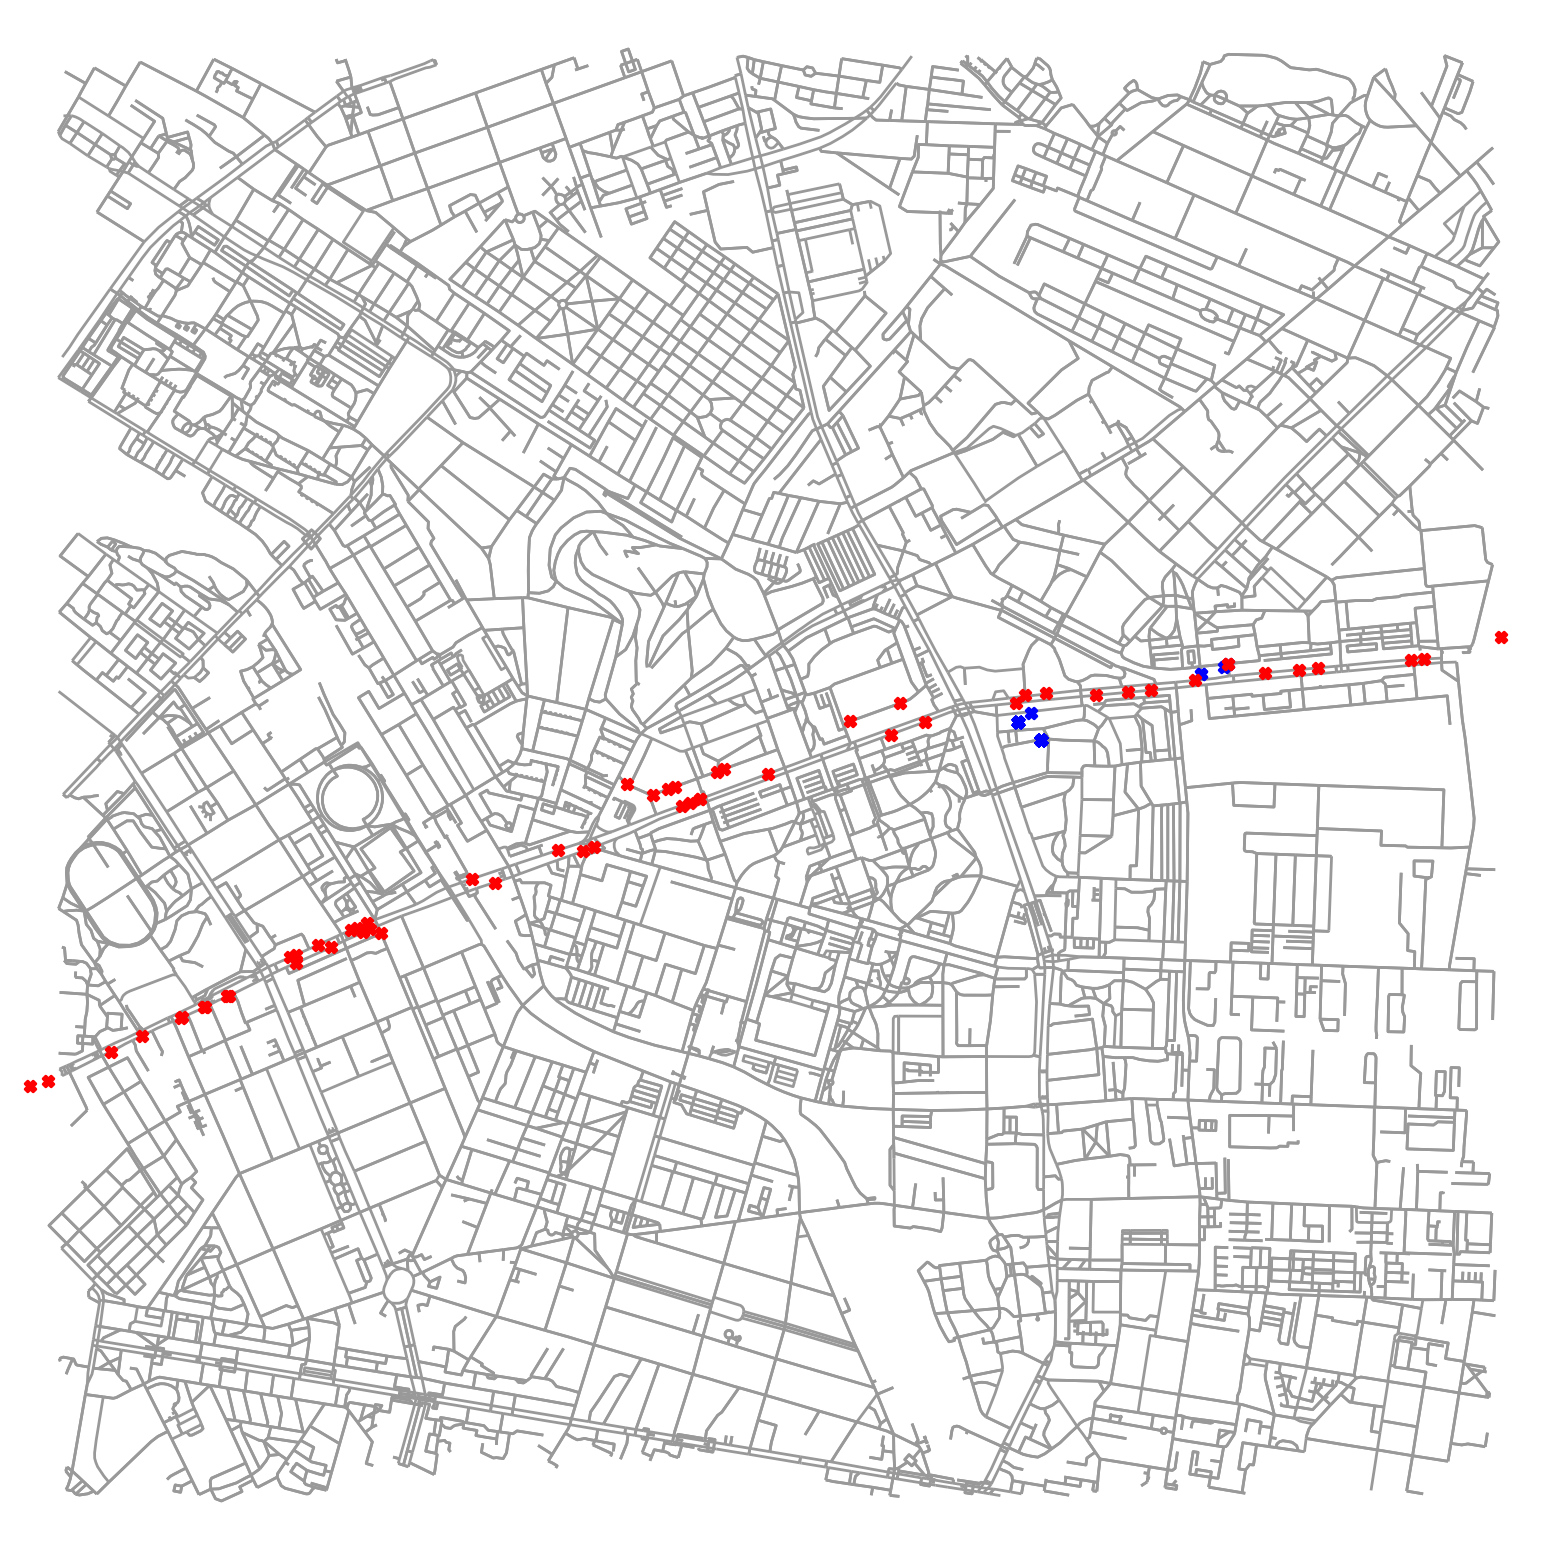

In [79]:
plot_street(test_predictions, test_labels, 'Landsberger Allee, Berlin, Germany')

#### Greifswalder Straße

In [29]:
greifswalder = prep_street('Greifswalder Straße')
len(greifswalder)

206

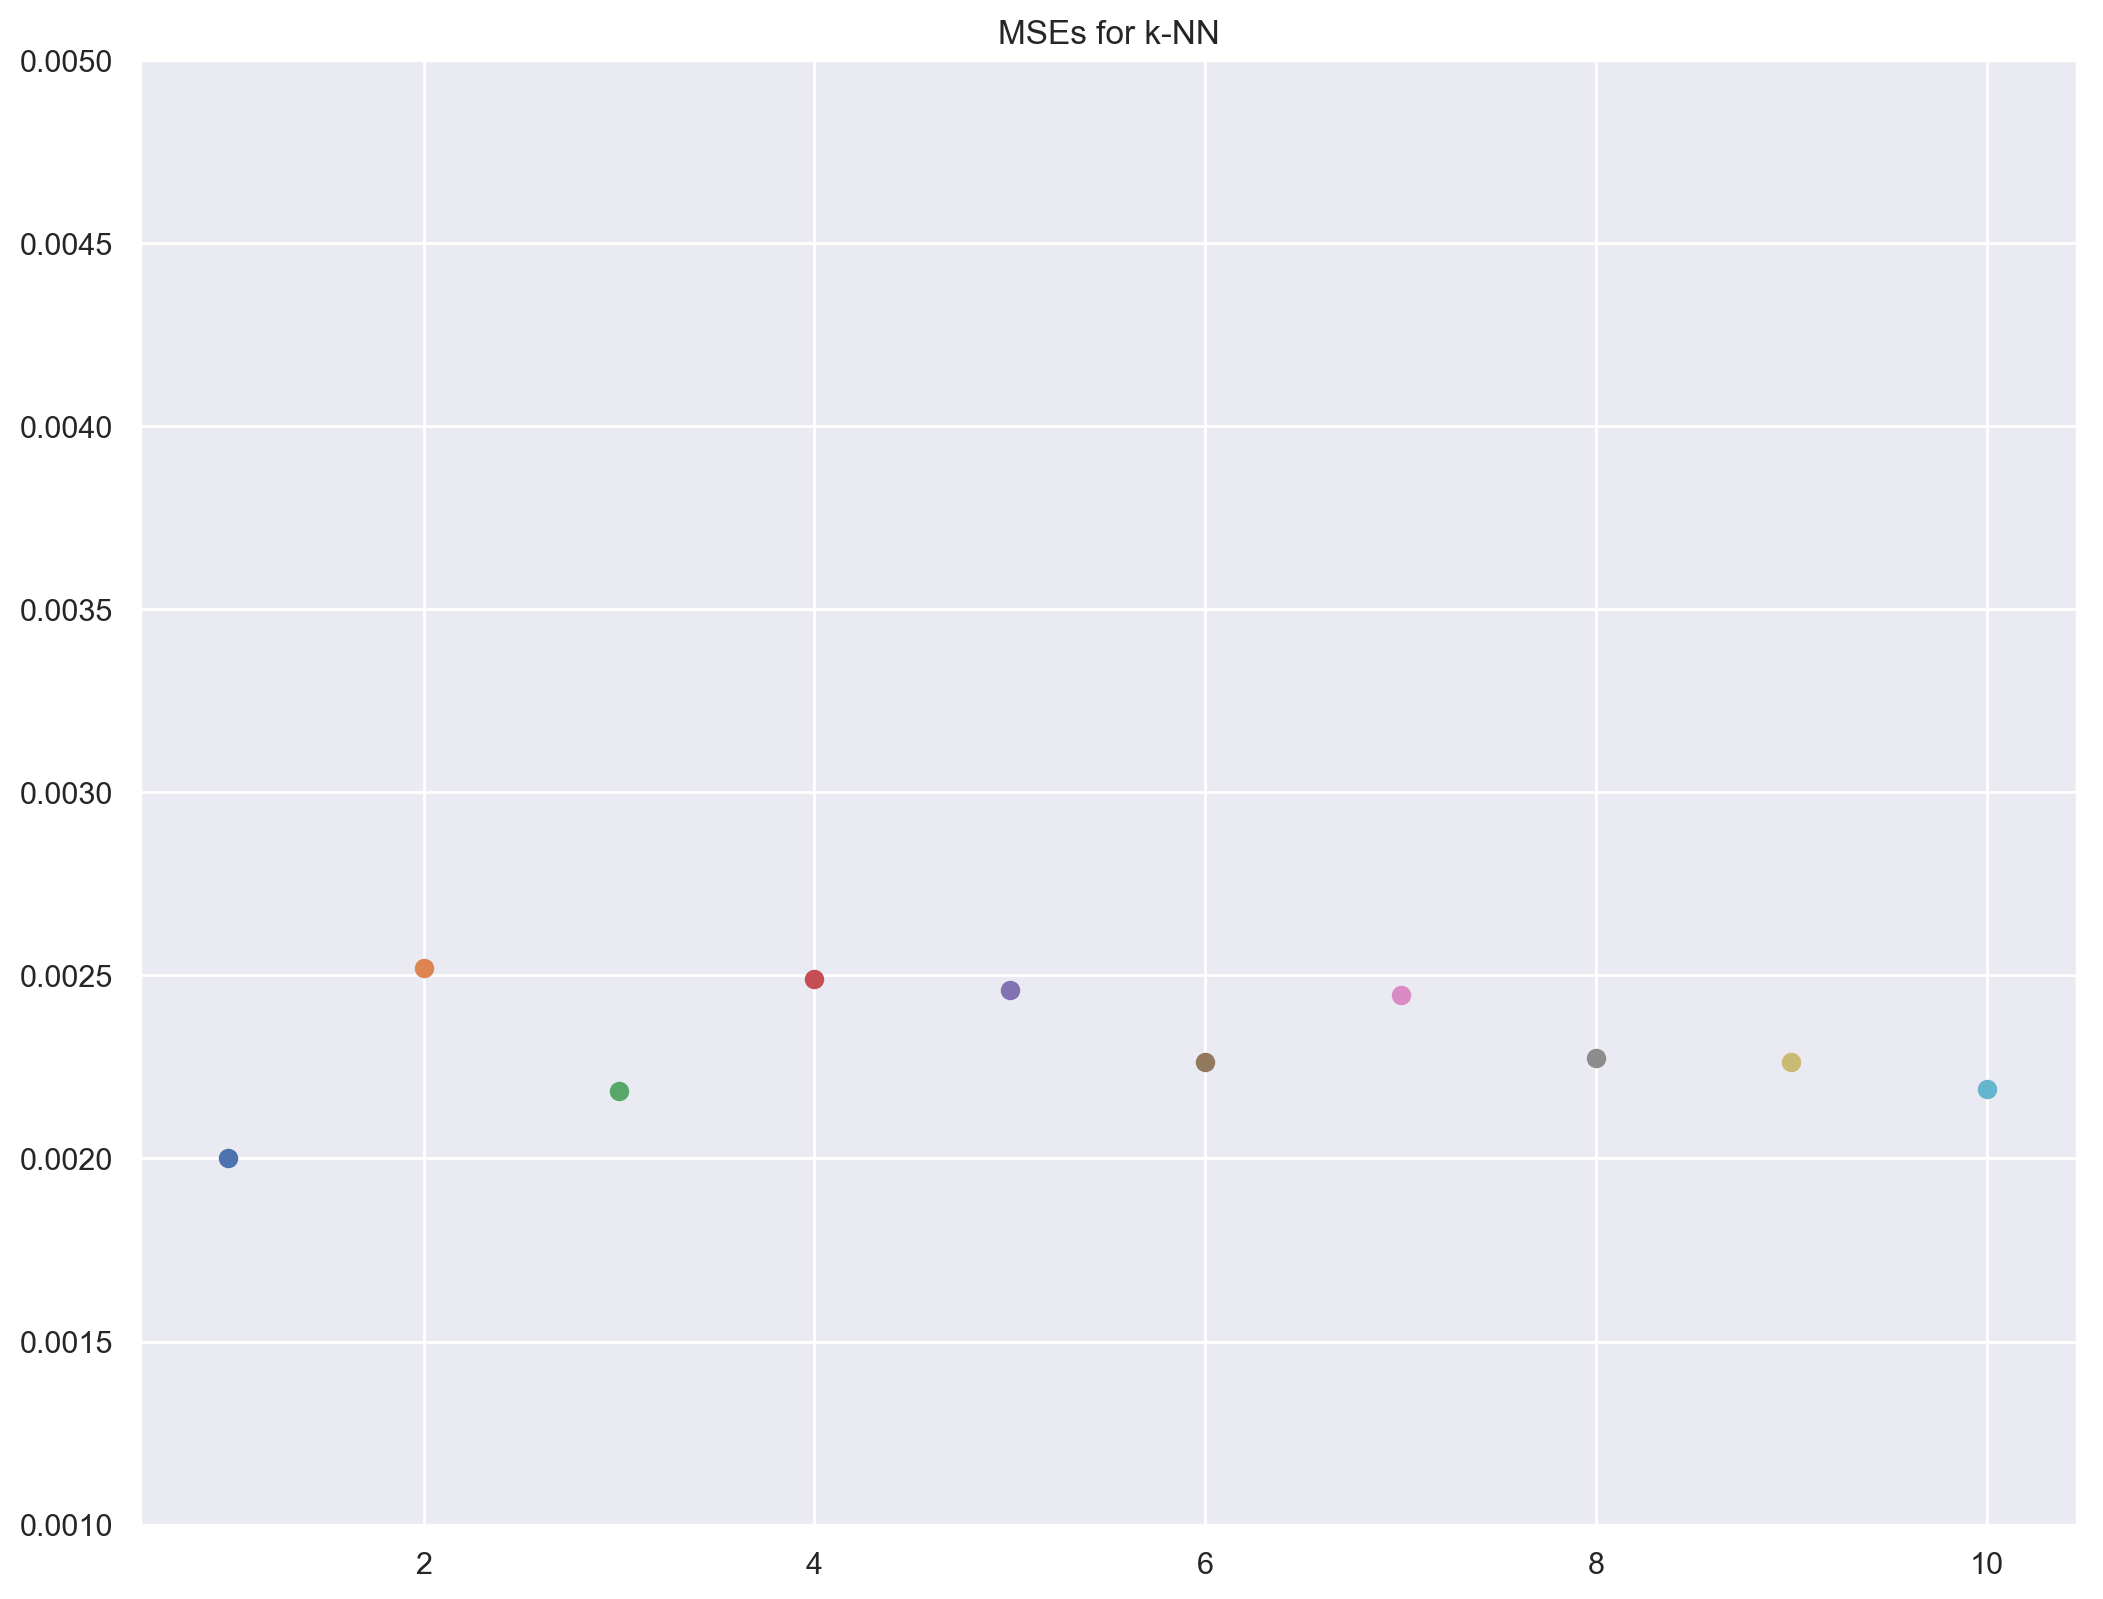

In [80]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim([0.001,0.005])
for i in range(1,11):
    _, knn_score, test_predictions, test_labels = fit_knn(greifswalder, i)
    ax.scatter(i, knn_score)
    
ax.set_title('MSEs for k-NN')
plt.show()

In [81]:
_, knn_score, test_predictions, test_labels = fit_knn(greifswalder, 1)
print(f'1-NN Test MSE: {knn_score}')

1-NN Test MSE: 0.0020003432397955297


#### Frankfurter Allee

In [71]:
frankfurter = prep_street('Frankfurter Allee')
len(frankfurter)

230

Text(0.5, 1.0, 'MSEs for k-NN')

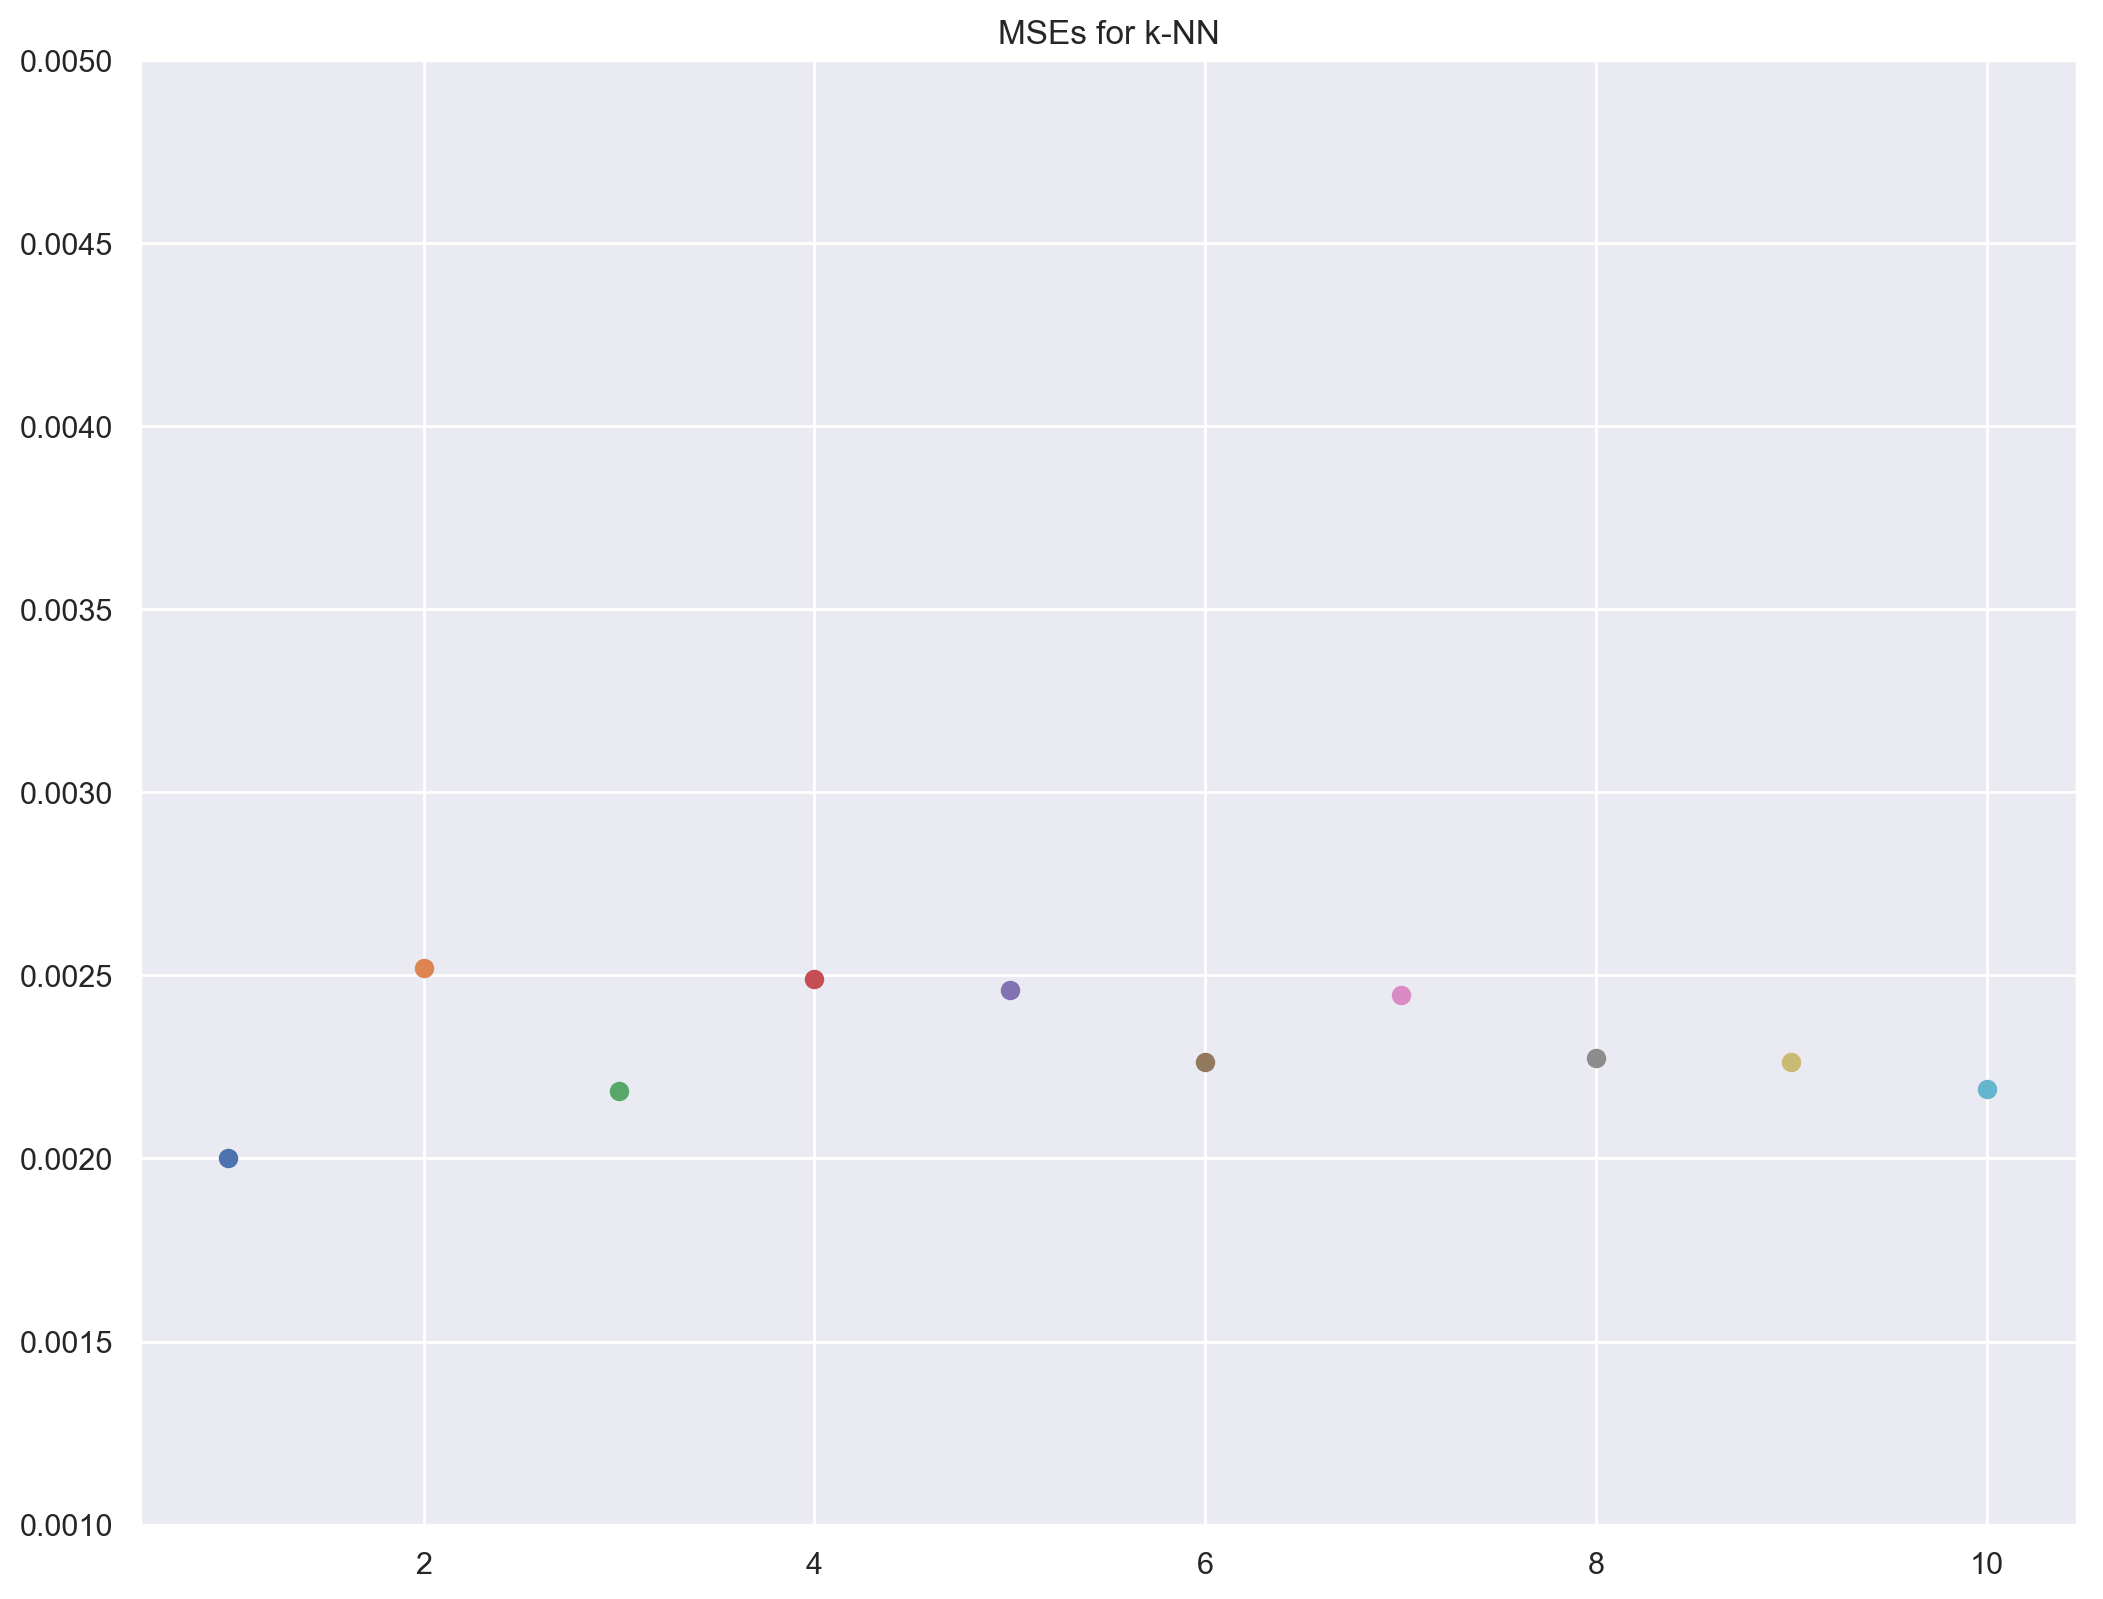

In [90]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim([0.001,0.005])
for i in range(1,11):
    _, knn_score, test_predictions, test_labels = fit_knn(greifswalder, i)
    ax.scatter(i, knn_score)
    
ax.set_title('MSEs for k-NN')

In [83]:
_, knn_score, test_predictions, test_labels = fit_knn(frankfurter, 1)
print(f'1-NN Test MSE: {knn_score}')

1-NN Test MSE: 8.811104465714248e-05


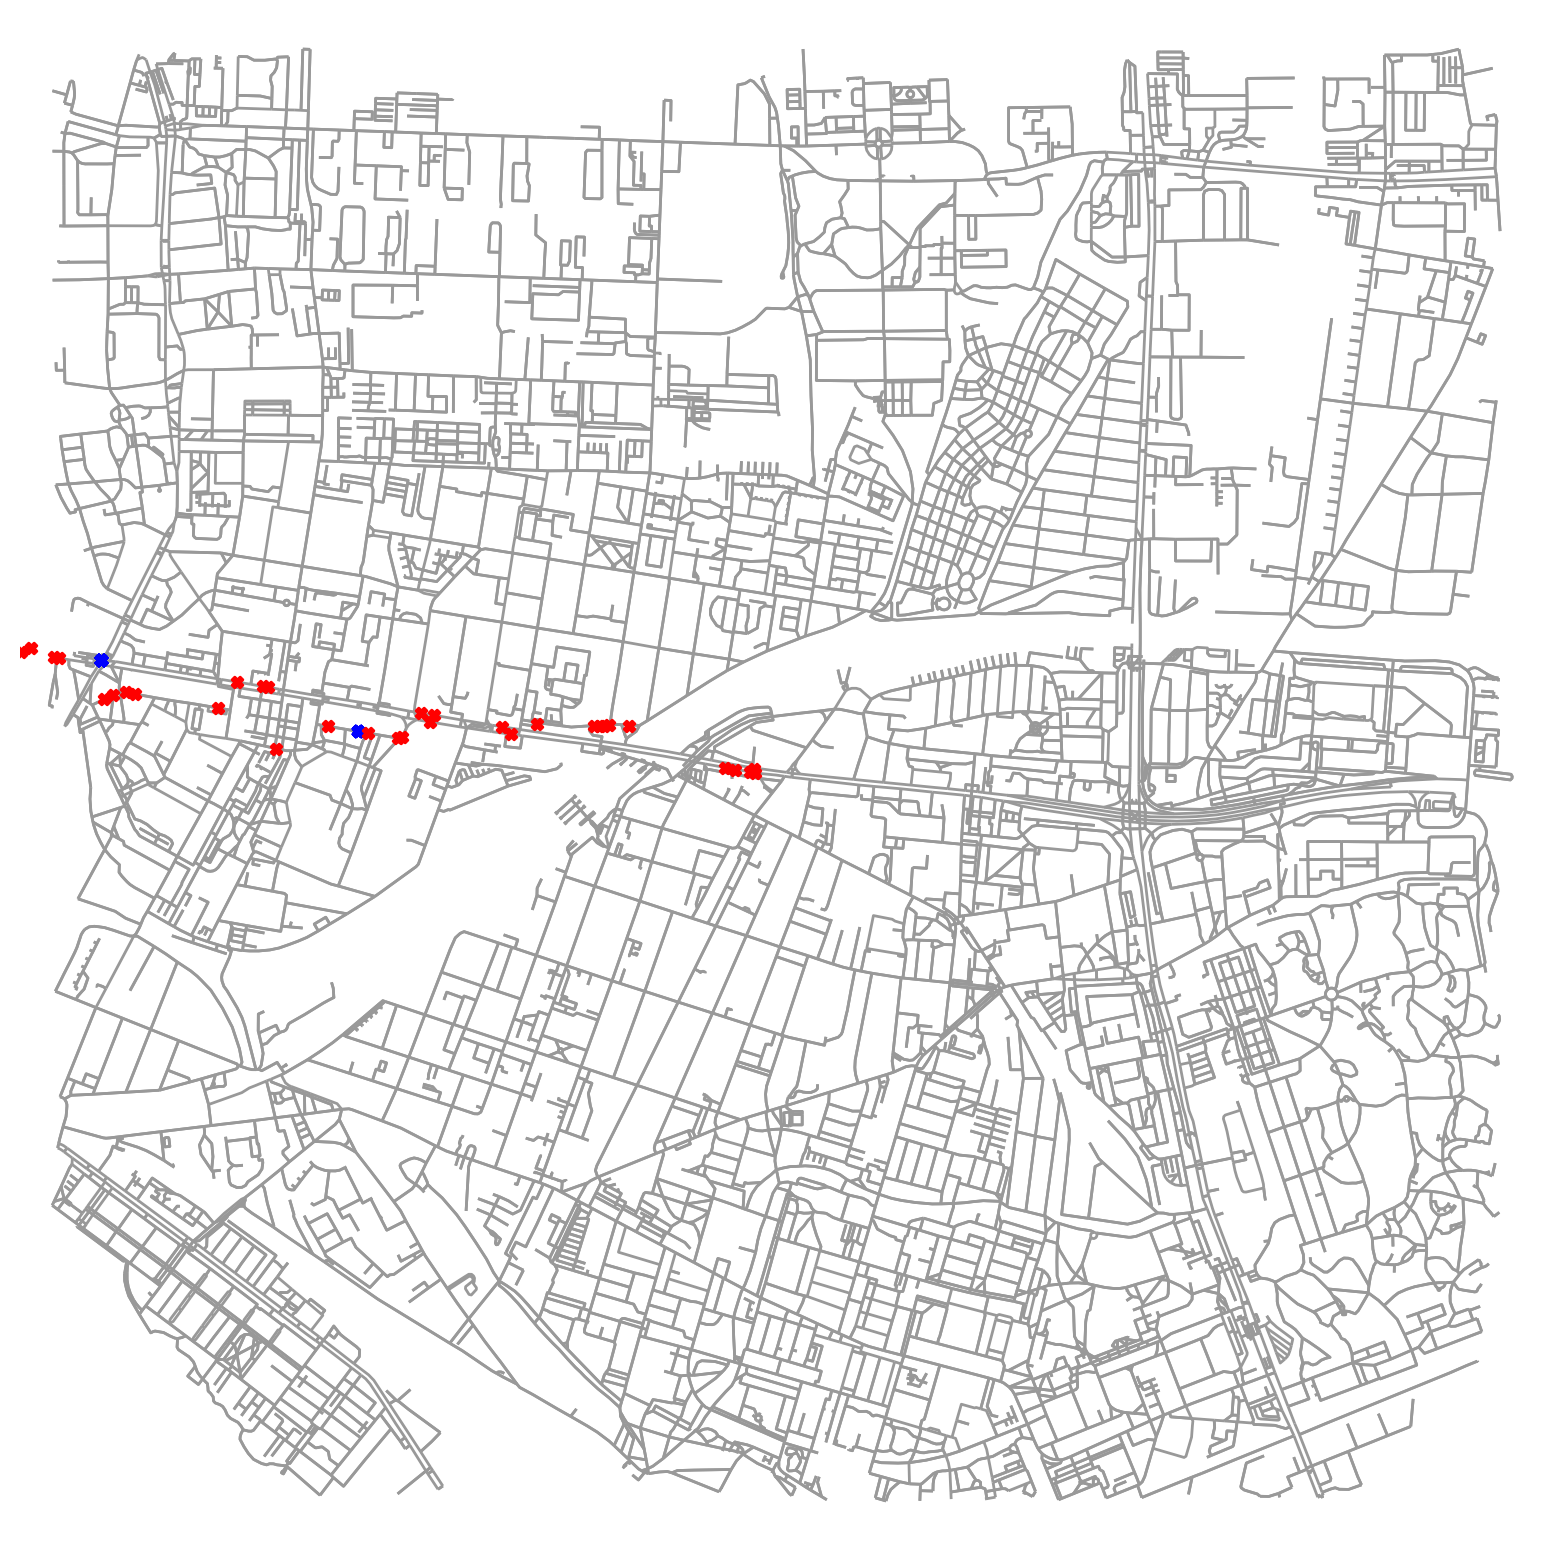

In [84]:
plot_street(test_predictions, test_labels, 'Frankfurter Allee, Berlin, Germany')